# Adaptive PDE discretizations on Cartesian grids
## Volume : Algorithmic tools
## Part : Convex functions and convex bodies
## Chapter : Minkowski and Meissner's problems

We illustrate the optimization of functionals defined over the set of convex bodies, through the numerical solution of the Reulaux, Meissner, and Minkowski problems, in dimension two and three. These geometric problems are described in more detail in the first section.

[**Summary**](Summary.ipynb) of volume Algorithmic tools, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Introduction](#1.-Introduction)
    * [1.1 Parametrization of convex bodies](#1.1-Parametrization-of-convex-bodies)
    * [1.2 Minkowski's problem](#1.2-Minkowski's-problem)
    * [1.3 Reulaux and Meissner's bodies of constant width](#1.3-Reulaux-and-Meissner's-bodies-of-constant-width)
    * [1.4 Constructing a r.h.s. for the Minkowski problem](#1.4-Constructing-a-r.h.s.-for-the-Minkowski-problem)
  * [2. Two dimensional convex bodies](#2.-Two-dimensional-convex-bodies)
    * [2.1 Explicit skeleton and area](#2.1-Explicit-skeleton-and-area)
    * [2.2 Validations](#2.2-Validations)
    * [2.3 Minkowski's problem](#2.3-Minkowski's-problem)
    * [2.4 The Reulaux triangle](#2.4-The-Reulaux-triangle)
  * [3. Geometry of three dimensional convex bodies](#3.-Geometry-of-three-dimensional-convex-bodies)
    * [3.1 Facet measures of the dual polytope](#3.1-Facet-measures-of-the-dual-polytope)
    * [3.2 Measure of the full polytope](#3.2-Measure-of-the-full-polytope)
    * [3.3 Validation on the cube and tetrahedron.](#3.3-Validation-on-the-cube-and-tetrahedron.)
    * [3.4 Sampling the sphere](#3.4-Sampling-the-sphere)
    * [3.5 Display of convex bodies](#3.5-Display-of-convex-bodies)
  * [4. Optimization over three dimensional convex bodies](#4.-Optimization-over-three-dimensional-convex-bodies)
    * [4.1 Minkowski's problem](#4.1-Minkowski's-problem)
    * [4.2 Meissner's body](#4.2-Meissner's-body)



**Acknowledgement.** Some of the experiments presented in these notebooks are part of 
ongoing research with Ludovic Métivier and Da Chen.

Copyright Jean-Marie Mirebeau, Centre Borelli, ENS Paris-Saclay, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; print(TocTools.displayTOC('Meissner','Algo'))

In [2]:
from agd import LinearParallel as lp
from agd import AutomaticDifferentiation as ad
from agd import Plotting
norm_infinity = ad.Optimization.norm_infinity

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import scipy
import scipy.optimize as sciopt

In [4]:
def reload_packages():
                from Miscellaneous.rreload import rreload
                global Plotting
                Plotting, = rreload([Plotting],rootdir="..")

### 0.1 Interface with `scipy.optimize`

This notebook presents some constrained, non-linear, non-convex, optimization problems, which are numerically addressed using the `scipy.optimize.minimize` method (with the `trust-constr` option).

For that purpose, the value, gradient, and hessian of the optimized function and of the constraints are required. We use sparse automatic differentiation to evaluate these quantities at a reasonable cost, and with minimal additional code. The following functions act as an interface between the sparse AD tools and the `scipy.optimize` package.

**Linear constraints, quadratic objective functions.**
Sometimes, the algebraic structure of the optimized function and/or of the constraint is simple enough, i.e. a sparse polynomial of degree $\leq 2$, that it can be entirely stored in an `ad` variable. The following code turns such `ad` variables into `scipy.optimize` constraints and objective functions, featuring their value, jacobian, and possibly hessian.

In [5]:
def LinearConstraint_AD(f):
    """
    Takes a linear constraint f>=0, 
    encoded as an ad.Sparse variable, 
    and turns it into a scipy compatible constraint.
    """
    return sciopt.LinearConstraint(f.tangent_operator(), lb = -f.value, ub=np.inf)

def QuadraticObjective_AD(f):
    """
    Takes a quadratic objective function, 
    encoded as an ad.Sparse2 variable,
    and returns fun, jac and hessian methods.
    """
    val0 = f.value
    grad0 = f.to_first().to_dense().gradient()
    n = len(grad0)
    hess0 = f.hessian_operator(shape=(n,n))
    def fun(x):  return val0+np.dot(grad0,x)+np.dot(x,hess0*x)/2
    def grad(x): return grad0+hess0*x
    def hess(x): return hess0
    return {'fun':fun,'jac':grad,'hess':hess}

**General non-linear constraints and objective functions.**
We use sparse automatic differentiation to evaluate the gradient and hessian of general non-linear constraints and functions. For numerical efficiency reasons, the constraints considered in this notebook are presented in a somewhat peculiar form: using *indices* $(i_k(x))_{0\leq k < K}$ and *weights*  $(g_k(x))_{0 \leq k < K}$, where $i_k(x) \in \{1,\cdots,I\}$ and $g_k(x) \in R$. 

The implied constraints
$$
    f_i(x) \geq 0
$$
for all $0 \leq i < I$, are defined as 
$$
    f_i(x) := \sum_{0 \leq k < K} 1_{i=i_k(x)} \ g_k(x).
$$
In other words, the $i$-th constraint is the `np.bincount` of the *indices* $(i_k(x))_{0\leq k < K}$, using the *weights*  $(g_k(x))_{0 \leq k < K}$. 

In [6]:
def NonlinearObjective(f,fargs):
    """Returns methods computing the value, gradient and hessian 
    of a given objective function f"""
    def fun(x):
        return f(x,*fargs)
    def grad(x): 
        return f(ad.Sparse.identity(constant=x),*fargs).to_dense().gradient()
    def hess(x): 
        return f(ad.Sparse2.identity(constant=x),*fargs).hessian_operator()
    return {'fun':fun,'jac':grad,'hess':hess}

def NonlinearConstraint(f,fargs):
    """
    Represents the constraint : np.bincount(indices,weights) >= 0,
    where (indices, weights) = f(x,*fargs)
    (Indices may be repeated, and the associated values must be summed.)
    """
    def fun(x):
        ind,wei = f(x,*fargs); 
        return np.bincount(ind,wei)
    def grad(x): 
        ind,wei = f(ad.Sparse.identity(constant=x),*fargs)
        triplets = (wei.coef.reshape(-1),(ind.repeat(wei.size_ad),wei.index.reshape(-1)))
        return scipy.sparse.coo_matrix(triplets).tocsr()
    def hess(x,v): # v is a set of weights, provided by the optimizer
        ind,wei = f(ad.Sparse2.identity(constant=x),*fargs)
        return np.sum(v[ind]*wei).hessian_operator()
    return sciopt.NonlinearConstraint(fun,0.,np.inf,jac=grad,hess=hess,keep_feasible=True)

### 0.2 Utility functions

The following functions turn AD objects into `scipy.optimize` objective and constraint.

In [7]:
def allclose_ad2(a,b,**kwargs): 
    return np.all([np.allclose(ai,bi,**kwargs) 
                   for ai,bi in zip(a.as_tuple(),b.as_tuple())])

### 0.3 Additional configuration

Visualize 3D interactive graphics with plotly.

In [8]:
use_plotly = False
if use_plotly: import plotly.graph_objects as go

## 1. Introduction

In this preliminary section, we introduce the addressed problems along with the notations and relevant material, both in dimension two and three.

### 1.1 Parametrization of convex bodies

Consider $X \subset S^d$ a finite set of $d$-dimensional vectors of unit norm, and let $u : X \to R$. 
Define the convex set
$$
    K(u) = \{v \in R^d; \forall x \in X, <v,x> \leq u(x)\},
$$
and denote by $K_x$ the facet associated to the direction $x\in X$
$$
    K_x(u) := \{v\in K; <v,x> = u(x)\}.
$$

**Relation with the subgradient.**
Let $u : X \to R$, and let $U$ denote the positively $1$-homogeneous extension of $u$, defined by
$$
    U(\lambda x) = \lambda u(x)
$$
for all $x \in X$, and all $\lambda \geq 0$. (Conventionally, $U=\infty$ elsewhere.)

Then the sets of interests are subgradients of $U$, as can easily be checked:
$$
    K(u) = \partial_0 U, \quad K_x(u) = \partial_x U,
$$
for all $x \in X$.

From this one obtains that $K(u+\tilde u) \supset K(u)+K(\tilde u)$ and $K_x(u+\tilde u) \supset K_x(u)+K_x(\tilde u)$ for any $u,\tilde u:X \to R$ and any $x \in X$.
Recall that the Minkowski sum of two sets is defined as $A+B = \{a+b; a\in A, b\in B\}$.

**Measure.** 
Denote by $|A|_n$ the $n$-dimensional Lebesgue measure of a set $A$. 
From the Brunn-Minkowski inequality, and the inclusions previously established using the subgradient interpretation, we obtain that following quantities are concave w.r.t $u : X \to R$
$$
    |K(u)|_d^\frac 1 d, \quad |K_x(u)|_{d-1}^\frac 1 {d-1}.
$$

**Barrier function.**
We are interesting in optimizing over convex bodies of the form $K(u)$, whose facet measures $|K_x(u)|_{d-1}$ are positive for all $x \in X$. For that purpose, the `BodyBarrier` function computes
$$
        S(u) = - \sum_{x \in X} \rho(x) \ln |K_x|_{d-1},
$$
where $\rho : X \to ]0,\infty[$ is a positive collection of weights.

The barrier function $S(u)$ is convex x.r.t $u:X \to R$, in view of the concavity of the facet measure (power $1/(d-1)$) established in the previous paragraph.


**Facet measures are derivatives of total measure.**
The derivative of the total volume of $K(u)$, with respect to the hyperplane separation distance $u(x)$, is the facet area $|K_x|$. More precisely
$$
    \frac {\partial |K(u)|_d}{\partial u(x)} = \frac{|K_x(u)|_{d-1}}{\|x\|}.
$$
Note that the formula slightly simplifies under our assumption $\|x\|=1$ that vectors are unit.

**Invariances.**
One has the scaling and translation properties
$$
    K(\lambda u) = \lambda K(u), \quad K(u+<z,\cdot>) = K(u)+z,
$$
for any $u: X \to R$, $\lambda \geq 0$, and $z \in R^d$.
The facets $K_x$, $x\in X$, obey similar relations obviously.

From this we deduce the homogeneity and invariance relations
$$
    |K(\lambda u+<z,\cdot>)|_d = \lambda^d |K(u)|_d, \quad |K_x(\lambda u+<z,\cdot>)|_{d-1} = \lambda^{d-1} |K_x(u)|_{d-1},
$$
and likewise for the barrier function $S(u)$.

**Case of non-unit vectors.**
If $\tilde X \subset R^d \setminus \{0\}$ contains non-unit vectors, and $\tilde u : \tilde X \to R$, then consider 
$X = \{x/\|x\|; x \in \tilde X\}$ and $u(x/\|x\|) := \tilde u(x)/\|x\|$ which defines the same convex body.

### 1.2 Minkowski's problem

Minkowski's problem asks for a convex body $K$ whose normals are distributed according to a given measure $\mu$ on $S^d$, which must be non-negative and have a vanishing first moment :
$$
    \int_{S^d} x\, d\mu(x) = 0
$$

**Discretization.**
Consider a finite sampling $X \subset S^d$, and denote by $\mu : X \to ]0,\infty[$ a discrete approximation of the original measure, now subject to the compatibility condition
$$
    \sum_{x \in X} \mu(x) x = 0
$$

Consider the convex functional of $u : X \to R$ defined as 
$$
    f(u) = -\ln |K(u)|_d + \sum_{x \in X} \mu(x) u(x).
$$
Then $f$ is convex, as established above. Furthermore any minimizer satisfies 
$$
    {-} \frac{|K_x(u)|_{d-1}}{|K(u)|_d} + \mu(x) = 0,
$$
in view of the expression of the partial derivatives of the volume $|K(u)|_d$. 

By homogeneity, $\tilde u := u/|K(u)|_d$ solves the discrete variant of Minkowski's problem, 
namely $|K_x(\tilde u)|_{d-1} = \mu(x)$ for all $x \in X$.

Note that the discretized Minkowski problem is a special case of the general problem, when $\mu$ is a discrete measure, hence general results apply and in particular there exists a solution.

**Invariance and normalization.**
By construction one has the invariance relation 
$$
f(u+<z,\cdot>) = f(u),
$$
for any $z \in R^d$.

In order to break this invariance, one can select e.g. the solution whose first order moment
$$
    \sum_{x\in X} u(x) \nu(x) x = 0
$$
vanishes, where $\nu : X \to [0,\infty[$ is some discrete measure such that $\sum_{x \in X} \nu(x) x x^\top \succ 0$.

Note that our numerical implementation requires that $u$ remains positive. While there exists such a solution, it is not obvious how to choose $\nu$ above so as to select it.

**Absence of constraints.**
By construction the minimizer of the above unconstrained optimization problem $|K_x(u)|_{d-1} = \mu(x) |K(u)|_d$.
Since the measure $\mu$ is pointwise positive, and the total volume is positive, we obtain that the facet areas of the minimizer are positive. Therefore it is useless to introduce an additional independent constraint ensuring the  positivity of the facet areas.

### 1.3 Reulaux and Meissner's bodies of constant width

The Reulaux triangle is defined as (resp. Meissner's tetrahedra are conjectured to be) the convex body of constant width $1$ in all directions which minimize the total volume, in dimension $d=2$ (resp. $d=3$). In other words, it solves
$$
    \min_K |K|_d,
$$
over the set of convex bodies in $R^d$, subject to the constraint for each element $x \in S^d$ of the unit sphere
$$
    \max_{v\in K} <v,x> - \min_{v \in K} <v,x> = l.
$$

The Reulaux triangle, which is not a triangle strictly speaking, is unique up to translations and rotations, and can be characterized as the intersection of three disks of unit radius at the vertices of an equilateral triangle of unit edge length.

There are two Meissner tetrahedra, up to translations and rotations. They are not tetrahedra strictly speaking, but nevetheless have a similar shape, with three sharp edges and three smooth edges.

**Convexity considerations.**
The Reulaux and Meisnner problems can be rephrased as the minimization of the concave functional
$$
    \min_{u:S^{d-1} \to R} |K(u)|_d,
$$
where $S^{d-1} := \{x \in R^d; \|x\|=1\}$ denotes the unit sphere. 
The problem is subject to the following linear constraints: for all $x \in S^{d-1}$
$$
    u(x) + u(-x) = 1.
$$
Note that a concave functional may have several *minimizers*, displaying a symmetry breaking phenomenon, as evidenced here. In contrast, the shape of constant width $1$ which maximizes volume is the sphere.

### 1.4 Constructing a r.h.s. for the Minkowski problem

The r.h.s. of the Minkowski problem must be a *positive measure, supported on the sphere, with vanishing first order moments*. 
The following function (implemented without any guarantee) takes a positive measure, and returns a positive measure with vanishing first order moments, hopefully close to it.

In [9]:
def normalize_moment(μ0,X):
    """
    Returns a measure usually close to μ but with zero first order moment. 
    """
    # Compute non-negative v such that sum_X v(x) x = 0
    z = lp.solve_AV(lp.dot_AA(X,X.T),X.sum(axis=1)) # 0 = sum_X (1+<z,x>)x
    v = 1-lp.dot_VV(z[:,None],X)
    assert np.all(v>=0) # No guarantee...
    
    # Compute non-negative weights p1,...,pd, m1,...,md
    p = v*(X >  0)
    m = v*(X <= 0)
    
    # Compute the correction
    a = lp.solve_AV(lp.dot_AA(X,p.T), (μ0*X).sum(axis=1))
    μ = μ0.copy()
    for i in range(len(X)):
        μ += np.abs(a[i])*(m[i] if a[i]>0 else p[i])

    return μ

In [10]:
np.random.seed(42)
nθ=10

# Use strictly increasing but somewhat random angles
θ = np.sort(np.pi*np.random.rand(nθ))+np.linspace(0,np.pi,nθ,endpoint=False)
X = np.array([np.cos(θ),np.sin(θ)]) # Unit vectors
μ0 = np.random.rand(nθ)

μ = normalize_moment(μ0,X)
assert np.allclose((μ*X).sum(axis=1),0)
assert np.all(μ>=0)

## 2. Two dimensional convex bodies


Two dimensional convex bodies $K(u)$ are simple, much simpler than three dimensional ones, because the skeleton of their boundary is independent of the width function $u:X \to R$, and can be obtained by sorting the points of $X$ in circular trigonometric order. This property holds assuming that all the facets $K_x(u)$, $x\in X$, have positive length. 

### 2.1 Explicit skeleton and area

Assume that $X \subset S^1$ is finite, where $S^1 = \{x \in R^d; \|x\|=1\}$ denotes unit circle. Denote by  $x_1,\cdots,x_N$ the elements of $X$, in counter-clockwise order. 
Then for $u : X \to R$, subject to assumptions specified later,
$$
    K(u) = \{v \in R^2; \forall x \in X, <v,x> \leq u(x)\},
$$
is a polygon whose vertices $v_1,\cdots,v_N$ are obtained by solving
$$
    <v_i,x_i> = u(x_i) \text{ and } <v_i,x_{i+1}> = u(x_{i+1}).
$$
The edges of this polygon are $K_{x_i}(u) = [v_{i-1},v_i]$. This relation holds so long as all have positive measure.

Note also that the edges of $K(u)$ are $K_{x_1}(u),\cdots,K_{x_N}(u)$ in counter-clokwise order. In particular the facet intersection $K_x(u)\cap K_y(u)$ is non-empty iff $x,y\in X$ are adjacent in counter-clockwise order.

In the following functions, we compute the vertices of $K(u)$, and the measure $|K(u)|$ and of $|K_x(u)|$ for all $x \in X
.

In [11]:
def DualVertices(u,X): 
    r"""
    Returns the vertices of the convex body 
    defined by the intersection of half spaces
    $\{v; \forall x \in X, <v,x>\leq u(x)\}$.
    
    Assumptions : X ordered counter-clockwise, no empty facet.
    """
    return lp.solve_AV([X,np.roll(X,-1,axis=1)],[u,np.roll(u,-1)])

In [12]:
def FullMeasure(u,X):
    V = DualVertices(u,X)
    #Returns the area of the star-shaped body of vertices V.
    return lp.det([np.roll(V,1,axis=1), V]).sum()/2

In [13]:
def FacetMeasures(u,X):
    V = DualVertices(u,X)
    iX = X/lp.dot_VV(X,X) # x/|x|^2
    # Returns the edge length, known to be orthogonal to X
    return lp.det([np.roll(V,1,axis=1)-V,iX])

Note that, in dimension $d=2$, these functions are polynomial w.r.t. the height function $u$. More precisely:
- `DualVertices(u,X)` is linear homogeneous w.r.t. $u$.
- `FullMeasure(u,X)` is quadratic homogeneous w.r.t. $u$.
- `FacetMeasures(u,X)`, the facet areas, is linear homogeneous w.r.t. $u$.

In applications, it will often be useful to have an explicit expression of the quadratic form involved.

Note that `FacetMeasures` is nothing else than the gradient of `FullMeasure(u,X)` w.r.t. $u$.

In [14]:
def FullMeasure_hess(X):
    """
    Returns a sparse matrix A such that 
    |K(u)| = <u, A u> /2 
    and thus
    [ |K_{x_1}(u)|, ..., |K_{x_n}(u)| ] = A u.
    """
    u_ad = ad.Sparse2.identity(shape = X.shape[1:])
    meas_ad = FullMeasure(u_ad,X)
    return meas_ad.hessian_operator()

In dimension $d=3$, these properties are lost, and the problem is more complex since the dual vertices change connectivity as the height $u$ varies. The skeleton of $K(u)$ can only be determined by calling a convex hull algorithm, whereas the volume $|K(u)|$ is *piecewise* cubic w.r.t $u$. 

In [15]:
np.random.seed(42)
nθ=10

# Use strictly increasing but somewhat random angles
θ = np.sort(np.pi*np.random.rand(nθ))+np.linspace(0,np.pi,nθ,endpoint=False)
X = np.array([np.cos(θ),np.sin(θ)]) # Unit vectors

# Choose u close to 1, so that all facets are non-empty
u = np.ones_like(θ)+0.2*np.random.rand(nθ)

### 2.2 Validations

We check basic mathematical consistency properties.

In [16]:
np.random.seed(42)
nθ=10

# Use strictly increasing but somewhat random angles
θ = np.sort(np.pi*np.random.rand(nθ))+np.linspace(0,np.pi,nθ,endpoint=False)
X = np.array([np.cos(θ),np.sin(θ)]) # Unit vectors

# Choose u close to 1, so that all facets are non-empty
u = np.ones_like(θ)+0.2*np.random.rand(nθ)

**The primal convex body.** 
Given $u : X \to ]0,\infty[$, define the *primal* convex body $\hat K(u)$ as the convex convex hull 
$$
    \hat K(u) = \mathrm{Conv}\{x/u(x); x \in X\}.
$$

Then $K(u)$ can be obtained as the *dual* convex body as follows
$$
    K(u) = \{v \in R^d; \forall w \in \hat K(u), <v,w>\leq 1\}.
$$

The next cell illustrates these two objects.

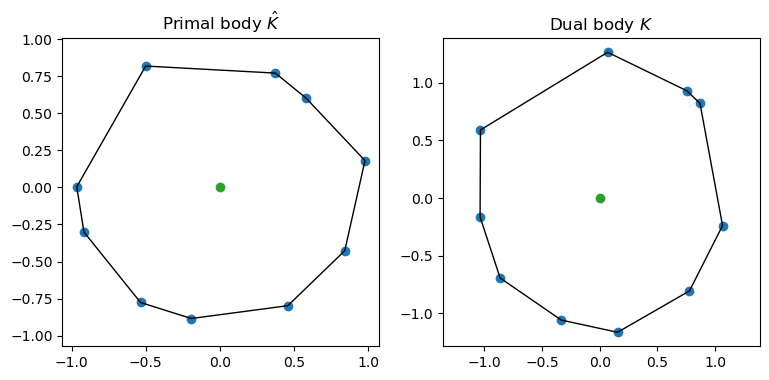

In [17]:
plt.figure(figsize=[9,4])

plt.subplot(1,2,1)
plt.title(r"Primal body $\hat K$"); V = X/u; 
plt.scatter(*V); plt.fill(*V,fill=False)
plt.scatter(0,0); plt.axis('equal')

plt.subplot(1,2,2)
plt.title(r"Dual body $K$"); V = DualVertices(u,X)
plt.scatter(*V); plt.fill(*V,fill=False)
plt.scatter(0,0); plt.axis('equal');

The edge lengths of the dual convex body, ordered trigonometrically.

In [18]:
FullMeasure_hess(X)*u

array([1.07701377, 0.15785642, 0.76418518, 1.29202076, 0.75492272,
       0.55663253, 0.64297539, 0.49982868, 0.7190144 , 0.63519102])

**Invariance to translations**

The area of a polytope, and of its facets, is invariant under translations. 
As a result, the corresponding quadratic form has a two dimensional kernel, corresponding to translations along the horizontal and vertical axes. The kernel elements take the form 
$$
    u(x) = <x,v>
$$
for some fixed vector $v \in R^2$, the translation vector of the polytope. The smallest eigenvalues of the volume quadratic form are obtained as follows.

In [19]:
scipy.sparse.linalg.eigsh(FullMeasure_hess(X),2,which='SM')

(array([-1.90500999e-16,  1.40663330e-15]),
 array([[ 0.42107966, -0.09013724],
        [ 0.3655609 ,  0.2019207 ],
        [ 0.28189554,  0.32696383],
        [-0.11331366,  0.47343614],
        [-0.40634358,  0.17626256],
        [-0.42262528,  0.02563894],
        [-0.32602337, -0.27032794],
        [-0.19934942, -0.40109405],
        [ 0.10256791, -0.47550201],
        [ 0.3106014 , -0.35815435]]))

We can check directly that the coordinates of the point $X$ belong to the kernel.

In [20]:
assert np.allclose(FullMeasure_hess(X)*X.T,0)

**Consistency between the full measure and the facet measures**

In [21]:
assert np.allclose(FacetMeasures(u,X),FullMeasure_hess(X)*u)

### 2.3 Minkowski's problem

The Minkowski problem, of constructing a convex body with a given distribution of facet normals, can be reformulated as the minimization of the following convex functional
$$
    f(u) = -\ln |K(u)|_d + \sum_{x \in X} \mu(x) u(x) + 
    \| \sum_{x\in X} u(x) \nu(x) x \|^2.
$$
The last term was introduced only to eliminate translation invariance. It vanishes at the minimizer.

In [22]:
def Minkowski(u,μ,ν,X):
    if np.any(ad.remove_ad(u)<=0): return np.nan # Require a positive u
    m = (u*ν*X).sum(axis=1) # Additional term for eliminating translations
    return -np.log(FullMeasure(u,X)) + (u*μ).sum() + (m**2).sum()

Note that a somewhat more efficient implementation could be obtained by replacing `Measure(DualVertices(u,X))` with 
$$
    \frac 1 2 <u,H u>
$$
where $H=$`FullMeasure_hess(X)` is precomputed. However, this may raise some compatibility issues with the automatic differentiation used within the Newton solver, and in any case the computation cost is very low for such one dimensional problems.

In [23]:
nUnk = 20

θ = np.linspace(0,2*np.pi,2*nUnk,endpoint=False)
X = np.array([np.cos(θ),np.sin(θ)])

Xsize = X.shape[1]
ν = np.ones(Xsize)
u0 = np.ones(Xsize) # Initial guess

In [24]:
np.random.seed(42)
μ = np.random.rand(Xsize)
μ[ np.array([5,12,17])]+=4 # Add a few big facets
μ = normalize_moment(μ,X)
u = ad.Optimization.newton_minimize(Minkowski,u0,(μ,ν,X)) 

Initialization, objective 42.60761704266221
Iteration 1, Newton step 0.0625, objective 15.777013746064972.
Iteration 2, Newton step 0.125, objective 10.822435392725485.
Iteration 3, Newton step 0.25, objective 8.209201799032432.
Iteration 4, Newton step 0.5, objective 7.240910995517211.
Iteration 5, Newton step 1.0, objective 7.0226296312883.
Iteration 6, Newton step 1.0, objective 7.008855742374957.
Iteration 8, Newton step 1.0, objective 7.00862407510096.
Iteration 10, Newton step 1.0, objective 7.008624075100958.
Convergence criterion satisfied, terminating.
Iteration 11, Newton step 1.0, objective 7.008624075100958.


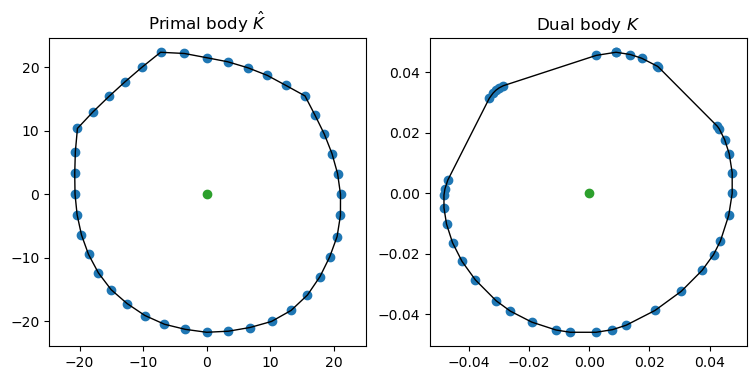

In [25]:
plt.figure(figsize=[9,4])

plt.subplot(1,2,1)
plt.title(r"Primal body $\hat K$"); V = X/u; 
plt.scatter(*V); plt.fill(*V,fill=False)
plt.scatter(0,0); plt.axis('equal')

plt.subplot(1,2,2)
plt.title(r"Dual body $K$"); V = DualVertices(u,X)
plt.scatter(*V); plt.fill(*V,fill=False)
plt.scatter(0,0); plt.axis('equal');

The obtained function $u$ is normalized as desired with a null moment.

In [26]:
assert np.allclose(0,(u*ν*X).sum(axis=1))

And Minkowski's problem is solved, by the renormalized function $\tilde u := u/|K(u)|_d$, in other words $|K_x(\tilde u)|_{1} = \mu(u)$.

In [27]:
tu = u/FullMeasure(u,X)
facet_measures = FullMeasure_hess(X) * tu
assert np.allclose(μ,facet_measures)

**Comment : Remove because too trivial for agd ?**

<!---
We test below the validity of the second order taylor expansion of the volume implemented above in `K_measure_taylor2`, using some arbitrary (but valid) points $X$ and values $u$.
--->

<!---
diff = K_measure_taylor2(u,X) - Measure(DualVertices(ad.Sparse2.identity(constant=u),X))
ad.simplify_ad(diff)
assert np.all([np.allclose(e,0) for e in (diff.value,diff.coef1,diff.coef2)])
--->

<!---
np.random.seed(42); nθ=10
θ = np.sort(np.pi*np.random.rand(nθ))+np.linspace(0,np.pi,nθ,endpoint=False)
X = np.array([np.cos(θ),np.sin(θ)]) # Unit vectors
u = np.ones_like(θ)+0.2*np.random.rand(nθ)

diff = K_measure_taylor2(u,X) - Measure(DualVertices(ad.Sparse2.identity(constant=u),X))
ad.simplify_ad(diff)
assert np.all([np.allclose(e,0) for e in (diff.value,diff.coef1,diff.coef2)])
--->

### 2.4 The Reulaux triangle

The [Reulaux triangle](https://en.wikipedia.org/wiki/Reuleaux_triangle) is obtained as the intersection of three unit disks centered at the vertices of an equilateral of unit edge length. Thus it is the central region in the following plot.

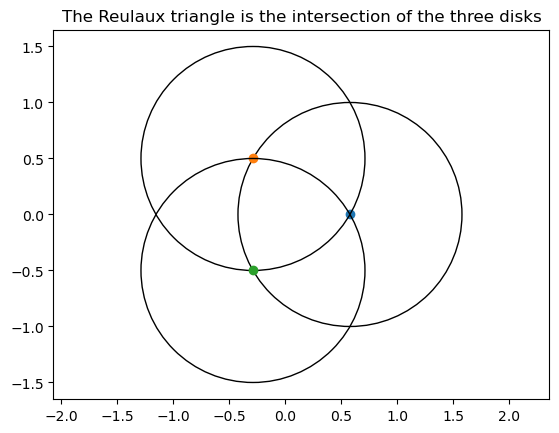

In [28]:
plt.title("The Reulaux triangle is the intersection of the three disks")
ax = plt.gca()
for θ in [0,2*np.pi/3,4*np.pi/3]:
    # Vertices of an equilateral triangle of unit edge length
    x = np.array([np.cos(θ),np.sin(θ)])/(2*np.sin(np.pi/3))
    ax.add_patch(plt.Circle(x, 1,fill=False))
    plt.scatter(*x)
plt.axis('equal');

Let us check that a numerical minimization of the volume, subject to a constraint of constant width, yields the Reulaux triangle. More precisely, we solve
$$
    \min_u |K(u)|_2
$$
where $u : X \to [0,1]$ is subject to $u(x)+u(-x) = 1$ for all $x \in X$, and to the additional constraint that 
$$
    |K_x(u)|_1 > 0,
$$
for all $x \in X$, in other words the edge lengths are positive.

<!---
Because of the chosen solver calling conventions, the second constraint is reformulated as follows, with $N$ the number of elements of $X$
$$
    {-} \Big(\prod_{x \in X} |K_x(u)|_1\Big)^{\frac 1 N} < 0.
$$
--->


In [29]:
# Choose the number of unknowns for the optimization problem. 
nUnk = 50 

θ = np.linspace(0,2*np.pi,2*nUnk,endpoint=False)
X = np.array([np.cos(θ),np.sin(θ)])

# The same unknown is used for u(x) and u(-x),
# i.e. u = np.concatenate([u_half,1-u_half]) 
u_half_guess = 0.5+0.05*np.cos(np.linspace(0,3*np.pi,nUnk,endpoint=False))

In [30]:
def volume_objective(u_half,X):
    r"""
    Returns the measure $|K(u)|_d$ of the convex body,
    where u concatenates u_half and 1-u_half.
    """
    u = np.concatenate([u_half,1-u_half]) 
    return FullMeasure(u,X)

def convexity_constraint(u_half,X):
    r"""
    Returns the facet areas $|K_x(u)|_{d-1}$, $x\in X$, 
    of the convex body, where u concatenates u_half and 1-u_half.
    """
    u = np.concatenate([u_half,1-u_half])
    return FacetMeasures(u,X)

Since `volume_objective` is quadratic, and `convexity_constraint` is linear, we can fully encode them in sparse AD variables, which in turn are converted to `scipy.optimize` format.

In [31]:
u0 = np.zeros_like(u_half_guess)
u_ad  = ad.Sparse.identity(constant=u0)
u_ad2 = ad.Sparse2.identity(constant=u0)

sol = sciopt.minimize(x0=u_half_guess,method='trust-constr',
    **QuadraticObjective_AD(volume_objective(u_ad2,X)),
    constraints = [LinearConstraint_AD(convexity_constraint(u_ad,X))],
    bounds = sciopt.Bounds(0.,1)
                     )

The dual body, on the right, approximates the Reulaux triangle as desired.

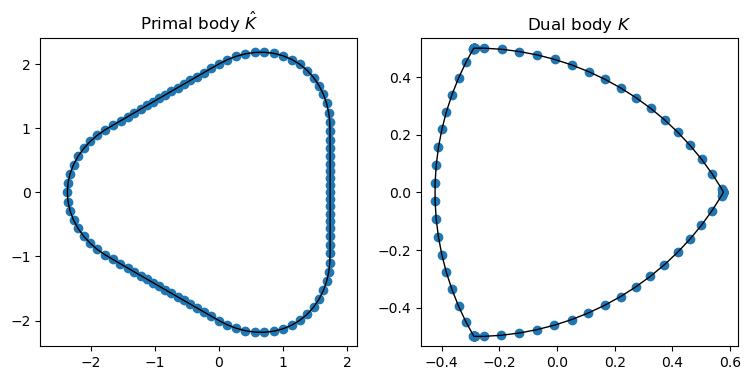

In [32]:
u_half_opt = sol.x

u=np.concatenate([u_half_opt,1-u_half_opt])
plt.figure(figsize=[9,4])

plt.subplot(1,2,1)
plt.title(r"Primal body $\hat K$"); V = X/u; 
plt.scatter(*V); plt.fill(*V,fill=False); plt.axis('equal')

plt.subplot(1,2,2)
plt.title(r"Dual body $K$"); V = DualVertices(u,X)
plt.scatter(*V); plt.fill(*V,fill=False); plt.axis('equal');

## 3. Geometry of three dimensional convex bodies

We compute the area of the facets of a polytope, from which we deduce the volume of the full polytope using Euler's formula identity for homogeneous functions. We then check these routines on various polygonal shapes, and finally we construct a regular sampling of the two dimensional unit sphere, which define the facet normal vectors in the next section.

### 3.1 Facet measures of the dual polytope

We use a convex hull algorithm to compute the primal convex body $\mathrm{Hull}\{x/u(x); x \in X\}$, under the form of a triangulated surface.
Each triangle corresponds to a vertex of the dual polytope. Two triangles sharing an edge correspond to two connected vertices of the dual polytope. From this point, we can compute the area of the facets of the dual polytope.

**Possible alternative implementation :** Using `scipy.spatial.HalfspaceIntersection` may be more natural, and marginally simpler.

<!---
from scipy.spatial import HalfspaceIntersection
halfspaces = np.concatenate([X,-u[None]]).T
hs = HalfspaceIntersection(halfspaces, np.zeros(3))
--->

In [33]:
def FacetMeasures(u,X):
    """
    Compute the measures of the facets of a three dimensional polytope.
    (Compatible with automatic differentiation)
    
    Output : facet indices, facet measures. 
    If an index appears several times, then the measures must be summed.
    """
    
    # Use a convex hull routine to triangulate the primal convex body
    primal_vertices = ad.remove_ad(X)/ad.remove_ad(u) # x/u(x)
    primal_body = scipy.spatial.ConvexHull(primal_vertices.T) 

    Xsize = X.shape[1]
    if primal_body.vertices.size!=Xsize:  # Then primal_body.vertices == np.arange(Xsize)
        raise ValueError("Non-convex primal body ! See",set(range(Xsize))-set(primal_body.vertices))

    # Use counter-clockwise orientation for all triangles
    S = primal_body.simplices.T
    N = primal_body.neighbors.T
    cw = np.sign(lp.det(X[:,S]))==-1 
    S[1,cw],S[2,cw] = S[2,cw],S[1,cw] 
    N[1,cw],N[2,cw] = N[2,cw],N[1,cw] 

    SX = X[:,S]
    Sg = lp.solve_AV(lp.transpose(SX), u[S]) # The vertices of the dual convex body
    SX2 = (SX**2).sum(axis=0)

    # Choose a reference simplex for each vertex, hence a reference point for each dual facet
    XS = np.full(u.shape,-1,S.dtype)
    XS[S] = np.arange(S.shape[1],dtype=S.dtype)[None]
    Xg = ad.remove_ad(Sg)[:,XS]

    Ng = Sg[:,N] # Gradient of the neighbor cells
    Srg = Xg[:,S] # Reference gradient associated to each vertex of the simplex

    # The triangle area, divided by two because each edge is counted twice.
    Sm = lp.det([SX, Sg[:,None]-Srg, np.roll(Ng,-1,axis=1)-Srg])/(2*SX2)

    return S.reshape(-1), ad.simplify_ad(Sm.reshape(-1))

### 3.2 Measure of the full polytope

Using Euler's identity for $d$-homogeneous functions
$$
    d |K(u)|_d = \sum_{x \in X} u(x) |K_x(u)|_{d-1},
$$
we obtain the measure of the full dual convex body.

In [34]:
def FullMeasure(u,X):
    facets,measures = FacetMeasures(u,X)
    return np.sum(u[facets]*measures)/len(X)

The above expression of the full measure is differentiable, and allows to recover the first and second derivatives of $|K(u)|$ w.r.t. $u$ in terms of the same derivatives of $|K_x(u)|_{x\in X}$.

However, noticing that $|K_x(u)|_{x\in X}$ is already the gradient of $|K(u)|$, one can be more efficient, and obtain e.g. the second order derivatives of $|K(u)|$ in terms of the first order derivatives of $|K_x(u)|_{x \in X}$, as discussed below and implemented in the next function.

**Second order Taylor expansion of the volume**

Differentiating the relation between the total volume, and the facet areas, we obtain the relation
$$
    \frac{\partial^2 |K(u)|_d}{\partial u(x) \partial u(y)} = \frac 1 {\|x\|} \frac{\partial K_x(u)}{\partial u(y)}.
$$

In other words, a first order differentiation of the facet areas, yields a second order differenation of the total volume. The following function takes advantage of this identity to implement a second order Taylor expansion of the volume.

This will be mainly useful in three dimensions, where the implementation of the volume functional is non-trivial due to topology changes. Note that the newton minimization method used to solve Minkowski's problem implicitly uses second order automatic differentiation.

<!---
The Newton method used above implicitly on the second order sparse automatic differentiation differentiation of the volume functional $K(u)$.

On the other hand, the `BodyBarrier` computes the facets areas, which are the first order derivatives of the volume functional. Therefore, a first order differentiation of BodyBarrier

A similar effect can therefore be achieved using first order differentiation of BodyBarrier, as illustrated below.

This is useful in three dimensions, where the implementation of the volume functional is non-trivial due to topology changes. It also allows us to access the third order derivatives of the volume functional. Those are not very useful in two dimensions, since $K(u)$ is a piecewise quadratic function of $u$, but make sense in three dimensions so as e.g. to exploit the fact that the barrier $S(u)$ is convex within an optimization method.
--->

In [35]:
def FullMeasure_ad2(u,X):
    """
    Second order Taylor expansion of $|K(u)|_d$.
    """
    # Compute the facet measures $|K_x(u)|_{d-1}$, $x \in X$, and their derivatives.
    u_ad = ad.Sparse.identity(constant=u)
    facets,measures = FacetMeasures(u_ad,X)
    
    # Reconstruct the volume of K, using Euler's identity for homogeneous functions.
    value = (u[facets]*measures.value).sum()/len(X) 
    
    # Gather first and second order derivatives of the volume
    coef1 = measures.value
    index = facets
    coef2 = measures.coef.reshape(-1)
    index_row = facets.repeat(measures.size_ad)
    index_col = measures.index.reshape(-1)
    
    return ad.Sparse2.spAD2(value,coef1,index,coef2,index_row,index_col)

### 3.3 Validation on the cube and tetrahedron.

The cube, with vertices $(\pm 1,\pm 1,\pm 1)$, and the octahedron, with vertices $(\pm 1,0,0), (0,\pm 1,0),(0,0,\pm 1)$ are dual polytopes.

In [36]:
octa_points = np.array([[1,0,0],[0,1,0],[0,0,1],[-1,0,0],[0,-1,0],[0,0,-1.]]).T
cube_points = np.array([[1,1,1],[1,1,-1],[1,-1,1],[1,-1,-1],[-1,1,1],[-1,1,-1],[-1,-1,1],[-1,-1,-1.]]).T

Let us compute the volume of the dual polytope to the octaherdon, also known as the cube, with a second order Taylor expansion using the previously implemented function.

In [37]:
u = np.ones(6)
cube_vol = FullMeasure_ad2(u,octa_points).to_dense()
cube_vol

denseAD2(array(8.),array([4., 4., 4., 4., 4., 4.]),
array([[0., 2., 2., 0., 2., 2.],
       [2., 0., 2., 2., 0., 2.],
       [2., 2., 0., 2., 2., 0.],
       [0., 2., 2., 0., 2., 2.],
       [2., 0., 2., 2., 0., 2.],
       [2., 2., 0., 2., 2., 0.]]))

In [38]:
u_ad = ad.Dense2.identity(constant=u)
assert allclose_ad2(cube_vol,FullMeasure(u_ad,octa_points))

A cube whose edge lengths are perturbed is of course a (three dimensional) rectangle, whose volume is explicit.

In [39]:
def rect_vol(u): return (u[0]+u[3])*(u[1]+u[4])*(u[2]+u[5])
assert allclose_ad2(cube_vol,rect_vol(u_ad))

The volume of the octahedron is $|K|_3 = 4/3$, and the area of its facets is $|K_x|_2 = \sqrt 3/2$. As a result the first order derivative of the volume is $|K_x|_2/\|x\| = 1/2$, since $\|x\|=\sqrt 3$ for all cube vertices. Let us check these identities.

In [40]:
octa_vol =  FullMeasure_ad2(np.ones(8),cube_points).to_dense()
assert np.allclose(octa_vol.value, 4/3) # Check the volume |K|
assert np.allclose(octa_vol.gradient(), 1/2) # Check the partial derivatives K_x
octa_vol.to_first()

denseAD(array(1.33333333),array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]))

### 3.4 Sampling the sphere

We sample the sphere using a regularly refined icosahedron mesh, projected onto it.
A method closely related to `geodesate` exists in the Mathematica(R) software.

In [41]:
def geodesate(points,triangles,n,nosym=False,tol=1e-6):
    """
    Generate a point set on a sphere, by projecting a regularly refined triangulation.
    (This implementation is stupid and inefficient, but will be enough for here.)
    Input : 
    - points, triangles : a triangulation of the sphere.
    - nosym : keep only a single representative among opposite points
    Output : the points of a refined triangulation.
    """
    out = np.zeros((3,1))
    def norm2(p): return (p**2).sum(axis=0)
    for i,j,k in triangles:
        pi,pj,pk = points[i],points[j],points[k]
        for u in range(n+1):
            for v in range(n+1-u):
                p = (u*pi+v*pj+(n-u-v)*pk)/n
                p /= np.sqrt(norm2(p))
                p = p[:,None]
                dist2 = np.min( norm2(out-p) )
                if nosym: dist2 = min(dist2, np.min( norm2(out+p) ) )
                if dist2<tol: continue 
                out = np.concatenate((out,p),axis=1)
    if nosym: out *= np.where(out[2]>=0,1,-1)
    return out[:,1:]

In [42]:
ico_points = np.array([[0., 0., -0.9510565162951536], [0., 0., 0.9510565162951536], [-0.85065080835204, 0., -0.42532540417601994], 
  [0.85065080835204, 0., 0.42532540417601994], [0.6881909602355868, -0.5, -0.42532540417601994], 
  [0.6881909602355868, 0.5, -0.42532540417601994], [-0.6881909602355868, -0.5, 0.42532540417601994], 
  [-0.6881909602355868, 0.5, 0.42532540417601994], [-0.2628655560595668, -0.8090169943749475, -0.42532540417601994], 
  [-0.2628655560595668, 0.8090169943749475, -0.42532540417601994], [0.2628655560595668, -0.8090169943749475, 0.42532540417601994], 
  [0.2628655560595668, 0.8090169943749475, 0.42532540417601994]])
ico_triangles = np.array([[2, 12, 8], [2, 8, 7], [2, 7, 11], [2, 11, 4], [2, 4, 12], [5, 9, 1], [6, 5, 1], [10, 6, 1], [3, 10, 1], [9, 3, 1], 
   [12, 10, 8], [8, 3, 7], [7, 9, 11], [11, 5, 4], [4, 6, 12], [5, 11, 9], [6, 4, 5], [10, 12, 6], [3, 8, 10], [9, 7, 3]])-1

In [43]:
def sphere_sampling(n,nosym=False):
    """A rather regular sapling of the sphere, obtained by refining an icosahedron mesh."""
    return geodesate(ico_points,ico_triangles,n,nosym)

Our samplings of the sphere and half sphere.

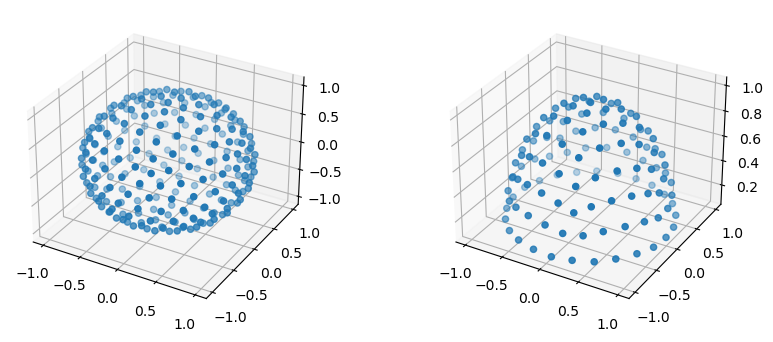

In [44]:
fig = plt.figure(figsize=[10,4])
fig.add_subplot(121,projection='3d').scatter(*sphere_sampling(5));
fig.add_subplot(122,projection='3d').scatter(*sphere_sampling(5,nosym=True));

Consistency check : The facets of the dual polytope to the icosahedron, the dodecahedron, all have the same area.

In [45]:
facets,measures = FacetMeasures(np.ones(12),ico_points.T)
dodecahedron_facet_areas = np.bincount(facets,weights=measures)
assert np.allclose(dodecahedron_facet_areas, dodecahedron_facet_areas[0])

**Volume validation by comparison of the two implementations**

<!---
### 3.3 Validation by hessian symmetry

A consistency test for our implementation `K_measure_taylor2` of the second order Taylor expansion of the volume $|K(u)|_3$, is to check that the hessian part is symmetric.

meas_sym = ad.Sparse2.spAD2(meas.value,meas.coef1,meas.index,
                            meas.coef2,meas.index_col,meas.index_row) #reverse row and col

diff = ad.simplify_ad(meas-meas_sym)
assert np.all([np.allclose(e,0) for e in (diff.value,diff.coef1,diff.coef2)])
--->

In [46]:
X=sphere_sampling(2)
Xsize = X.shape[1]

# All facets are non-empty if u is close enough to 1
np.random.seed(42)
u = 1+0.1*np.random.rand(Xsize)

# Second order Taylor expansions of the volume
u_ad = ad.Dense2.identity(constant=u)
assert allclose_ad2(FullMeasure(u_ad,X), FullMeasure_ad2(u,X).to_dense())

### 3.5 Display of convex bodies

**Using plotly (R)**
The plotly library can be used to display triangulated surfaces and wireframes, hence also the primal and dual convex bodies which are of interest in this notebook. This requires a little bit of preprocessing, implemented in the `agd.Plotting.plotly_primal_dual_bodies`, whose code is closely related to the `FacetMeasures` function.


**Using Mathematica (R)**
The Mathematica(R) software can also be used to display three dimensional convex bodies, and the dual bodies, thanks to the following code snippet.

```
Needs["TetGenLink`"];
ShowPrimalDualBody[X_] := 
 Module[{primalPts, surface, dualPts, dualSurface},
  {primalPts, surface} = TetGenConvexHull[X];
  dualPts = Inverse[{#1, #2, #3}].{1, 1, 1} & @@@ (primalPts[[#]] & /@ surface);
  {dualPts, dualSurface} = TetGenConvexHull[dualPts];
  
  Graphics3D[{EdgeForm[None], GraphicsComplex[#1, Polygon[#2]]}, 
     Boxed -> False] & @@@ {{primalPts, surface}, {dualPts, dualSurface}}
  ]
```

Arrays are exported to the `Mathematica` format using the following method.

In [47]:
def to_mathematica(Z): return str(Z.T.tolist()).replace("[","{").replace("]","}")

## 4. Optimization over three dimensional convex bodies

We present discretizations of Minkowski's and Meissner's problems, which are optimization problems posed over the set of three dimensional convex bodies. The presentation closely follows the two dimensional case. A Newton method is used to numerically minimize Minkowski's (convex) functional, and a more generic routine for Meissner's (non-convex) one.

### 4.1 Minkowski's problem

Let us implement the minimized functional:
$$
    f(u) = -\ln |K(u)|_d + \sum_{x \in X} \mu(x) u(x) + 
    \| \sum_{x\in X} u(x) \nu(x) x \|^2.
$$

In [48]:
def Minkowski3(u,μ,ν,X):
    try: meas = FullMeasure(u,X)
    except ValueError: return np.nan
    
    m = np.sum(u*ν*X,axis=1)
    return -np.log(meas)+ np.sum(u*μ) + np.sum(m**2)

In [49]:
X=sphere_sampling(2)
Xsize = X.shape[1]

# Generate a rhs for Minkowski's problem
np.random.seed(42)
μ = np.random.rand(Xsize) # Random facet areas
μ[np.random.randint(len(μ),size=3)] += 6 # Add a few big facets
μ = np.maximum(μ,0.01) # Avoid excessively small facets
μ = normalize_moment(μ,X)

ν = np.ones(Xsize)
u0 = np.ones(Xsize)

In [50]:
%%time
u = ad.Optimization.newton_minimize(Minkowski3,u0,(μ,ν,X))

Initialization, objective 49.74163077605771
Iteration 1, Newton step 0.03125, objective 35.371591230312916.
Iteration 2, Newton step 0.0625, objective 23.81170183594524.


Iteration 3, Newton step 0.125, objective 15.690010081307584.
Iteration 4, Newton step 0.25, objective 11.608839312954025.
Iteration 5, Newton step 0.5, objective 10.15086969600167.


Iteration 6, Newton step 1.0, objective 9.823492927986397.
Iteration 8, Newton step 1.0, objective 9.802483829645457.


Iteration 10, Newton step 1.0, objective 9.802483750734988.
Convergence criterion satisfied, terminating.
Iteration 12, Newton step 1.0, objective 9.80248375073499.
CPU times: user 879 ms, sys: 243 ms, total: 1.12 s
Wall time: 1.09 s


Let us check the solution.

In [51]:
facets,measures = FacetMeasures(u,X)
measures = np.bincount(facets,weights=measures)
volume = np.dot(u,measures)/3 # Reconstructed using Euler's identity

assert np.allclose(measures,μ*volume) # Minkowski problem is solved

The Newton solver computation time is dominated by the differentiation of the volume functional. 
An easy way to improve it is to rely on the `FullMeasure_ad2` variant.


In [52]:
def Minkowski3_ad(u,μ,ν,X):
    try: meas_ad = FullMeasure_ad2(u,X)
    except ValueError: return np.nan # If a facet is empty
    
    u_ad = ad.Sparse2.identity(constant=u)
    m_ad = (u_ad*ν*X).sum(axis=1)
    return -np.log(meas_ad) + (u_ad*μ).sum()+(m_ad**2).sum()

In [53]:
%%time
u_faster = ad.Optimization.newton_minimize(Minkowski3,u0,(μ,ν,X),
        f_value_gradient_direction = Minkowski3_ad) # AD routine provided

Initialization, objective 49.74163077605771
Iteration 1, Newton step 0.03125, objective 35.37159123031173.


Iteration 2, Newton step 0.0625, objective 23.81170183594491.
Iteration 3, Newton step 0.125, objective 15.6900100813076.
Iteration 4, Newton step 0.25, objective 11.608839312954004.
Iteration 5, Newton step 0.5, objective 10.15086969600167.
Iteration 6, Newton step 1.0, objective 9.823492927986397.
Iteration 8, Newton step 1.0, objective 9.802483829645457.
Iteration 10, Newton step 1.0, objective 9.802483750734988.
Convergence criterion satisfied, terminating.
Iteration 12, Newton step 1.0, objective 9.80248375073499.
CPU times: user 85.8 ms, sys: 59.5 ms, total: 145 ms
Wall time: 111 ms


In [54]:
assert np.allclose(u,u_faster)

In [55]:
reload_packages()

In [56]:
primal_data,dual_data = Plotting.plotly_primal_dual_bodies(X/u)
#with open('convex_body.txt','w') as f: f.write(to_mathematica(X/u))

The soluton to Minkowski's problem is the *dual convex body* shown below.
Note that it has a few big facets, since a few large values were introduced in the measure $\mu$.
![Dual body](Illustrations/Meissner/Minkowski_dual.png)


The *primal convex body* has a few pointy vertices, in place of the large facets.
![Primal body](Illustrations/Meissner/Minkowski_primal.png)

In [57]:
if use_plotly: go.Figure(data=dual_data) # Uncomment for a live plotly view of the dual body

In [58]:
if use_plotly: go.Figure(data=primal_data) # Uncomment for a live plotly view of the primal body

### 4.2 Meissner's body

We numerically address Meissner's problem, of finding the convex body of minimal volume and with a given width. The implementation is closely related to the Relaux problem, described above.

In [59]:
# Choose the sphere sampling
X=sphere_sampling(4,nosym=True)
nUnk = X.shape[1]
X = np.concatenate([X,-X],axis=1)
u_guess = 0.5 +0.003*np.cos(np.linspace(0,3*np.pi,nUnk,endpoint=False))

In [60]:
def volume_objective(u_,X):
    r"""
    Returns the measure $|K(u)|_d$ of the convex body,
    where u concatenates u_ and 1-u_.
    """
    u = np.concatenate([u_,1.-u_])
    try: facets,measures = FacetMeasures(u,X)
    except ValueError: return np.inf
    
    return np.sum(u[facets]*measures)/3.

def convexity_constraint(u_,X):
    u = np.concatenate([u_,1.-u_])
    try: return FacetMeasures(u,X)
    except ValueError: return np.arange(len(u)),np.full(len(u),-1.)

The addressed problem consists in the minimization of a concave problem, subject to convex constraints.

Commented : nlopt variant.

<!---
#import nlopt # !pip install nlopt

# Choose the sphere sampling
X=sphere_sampling(2,nosym=True)
nUnk = X.shape[1]
X = np.concatenate([X,-X],axis=1)

# The same unknown is used for u(x) and u(-x),
# i.e. u = np.concatenate([u_half,1-u_half]) 
u_half_guess = 0.5 +0.0*np.cos(np.linspace(0,3*np.pi,nUnk,endpoint=False))

def objective(u_half,grad):
    r"""
    Returns the measure $|K(u)|_d$ of the convex body,
    where u concatenates u_half and 1-u_half.
    """
    u = np.concatenate([u_half,1-u_half])
    try: facets,measures = ConvexEntropy.BodyBarrier(u,X,"FacetMeasures")
    except ValueError: return np.inf
    measures = np.bincount(facets,weights=measures)
    
    if grad.size>0: grad[:] = measures[:nUnk]-measures[nUnk:]
    resval = (u*measures).sum()/3 # Volume reconstructed using Euler's identity
    print("Objective",resval)
    return resval
    
def constraint(u_half,grad):
    r"""
    Returns minus the geometric mean of the facet areas $|K_x(u)|_{d-1}$, $x\in X$, 
    of the convex body, where u concatenates u_half and 1-u_half.
    """
    if grad.size>0: 
        u_half = ad.Sparse.identity(constant=u_half)

    u = np.concatenate([u_half,1-u_half]) 
    res = -np.exp(-ConvexEntropy.BodyBarrier(u,X)/len(u))
    
    if grad.size>0: 
        grad[:] = res.to_dense().coef
    
    resval = float(ad.remove_ad(res))
    return np.inf if np.isnan(resval) else resval 


# Choose the algorithm 
# L : Local
# D : uses Derivatives
# SLSQP : Sequential Least Squares Quadratic Programming
opt = nlopt.opt("LD_SLSQP",nUnk)
opt.set_maxeval(100)

# 0 <= u(x) <= 1
opt.set_lower_bounds(0)
opt.set_upper_bounds(1)

opt.set_min_objective(objective)
opt.add_inequality_constraint(constraint)
--->

In [61]:
%%time
sol = sciopt.minimize(x0=u_guess,method='trust-constr',
    **NonlinearObjective(volume_objective,(X,)),
    constraints = [NonlinearConstraint(convexity_constraint,(X,))],
    bounds = sciopt.Bounds(0.,1),options={'verbose':1,'maxiter':150,'gtol':1e-9})

The maximum number of function evaluations is exceeded.
Number of iterations: 150, function evaluations: 184, CG iterations: 168, optimality: 2.47e-08, constraint violation: 0.00e+00, execution time:  9.2 s.
CPU times: user 6.71 s, sys: 5.66 s, total: 12.4 s
Wall time: 9.3 s


In [62]:
u=np.concatenate([sol.x,1-sol.x])
primal_data,dual_data = Plotting.plotly_primal_dual_bodies(X/u)
#with open('convex_body.txt','w') as f: f.write(to_mathematica(X/u))

The conjecture is that there are two optimal shapes (up to rotations and translations), which are tetrahedra like objects, with three sharp edges and three rounded edges. The global shape is indeed retrieved with our numerical solver; a finer tuning of the optimizer may allow to better distinguish the two edge classes.

![Dual body](Illustrations/Meissner/Meissner_dual.png)

In [63]:
if use_plotly: go.Figure(data=dual_data)